#04. PyTorch Custom Datasets

A custom dataset is a collection of data relating to a specific problem you're working on.

In essence, a custom dataset can be comprised of almost anything.

For example, if we were building a food image classification app like Nutrify, our custom dataset might be images of food.

Or if we were trying to build a model to classify whether or not a text-based review on a website was positive or negative, our custom dataset might be examples of existing customer reviews and their ratings.

Or if we were trying to build a sound classification app, our custom dataset might be sound samples alongside their sample labels.

Or if we were trying to build a recommendation system for customers purchasing things on our website, our custom dataset might be examples of products other people have bought.

0. Importing PyTorch and setting up device agnostic code

In [1]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.4.0+cu121'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

##1. Get data

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


##2. Become one with the data(data preparation and data exploration).

In [4]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath,dirnames,filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'


In [6]:
#Setup train and testing paths.

train_dir = image_path / "train"

test_dir = image_path / "test"

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.2. Visualize and Image.

Let's write some code to:

1. Get all the image paths.
2. Pick a random image path using Python's random.choice().
3. Get the image class name using `pathlib.Path.parent.stem`
4. Open the image with Python's PIL.
5. Show image and print metadata.



Random image path: data/pizza_steak_sushi/train/sushi/385154.jpg
Image class: sushi
Image height: 382
Image width: 512


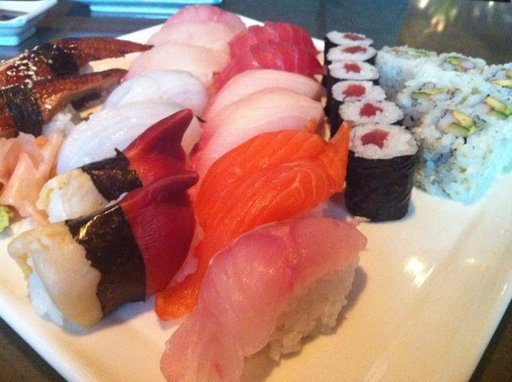

In [7]:
import random
from PIL import Image

#Set the seed.
# random.seed(42)

#1. Get all image paths.
image_path_list = list(image_path.glob("*/*/*.jpg"))

#2. Pick a random image path.
random_image_path = random.choice(image_path_list)


#3. Get image class from the path name (the image is the name of the directory where the image is stored.)
image_class = random_image_path.parent.stem


#4. Open Image.
img = Image.open(random_image_path)

#5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

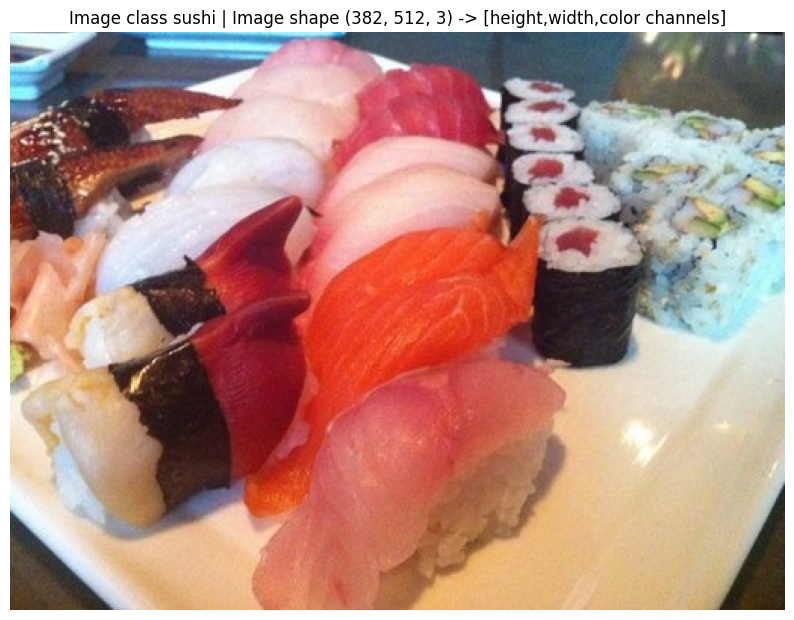

In [8]:
#Visualize the data using matplotlib.
import numpy as np
import matplotlib.pyplot as plt

#Turn the inmage into an array
img_as_array = np.asarray(img)

#Plot the image with matplotlib
plt.figure(figsize=(10,8))
plt.imshow(img_as_array)
plt.title(f"Image class {image_class} | Image shape {img_as_array.shape} -> [height,width,color channels]")
plt.axis(False);

array([[[141, 171, 179],
        [140, 171, 176],
        [138, 167, 173],
        ...,
        [ 26,  32,  32],
        [ 64,  70,  68],
        [114, 120, 118]],

       [[209, 242, 249],
        [211, 244, 251],
        [213, 244, 249],
        ...,
        [ 26,  32,  32],
        [ 56,  62,  62],
        [ 98, 104, 102]],

       [[208, 247, 254],
        [213, 250, 255],
        [218, 253, 255],
        ...,
        [ 51,  59,  61],
        [ 69,  77,  79],
        [100, 109, 108]],

       ...,

       [[ 77,  60,  34],
        [ 77,  60,  34],
        [ 80,  60,  35],
        ...,
        [ 49,  32,  12],
        [ 48,  30,  10],
        [ 51,  34,  14]],

       [[ 77,  57,  32],
        [ 76,  56,  31],
        [ 77,  57,  32],
        ...,
        [ 47,  29,   9],
        [ 48,  27,   8],
        [ 54,  36,  16]],

       [[ 73,  53,  28],
        [ 73,  53,  28],
        [ 74,  54,  29],
        ...,
        [ 57,  36,  17],
        [ 50,  29,  10],
        [ 55,  34,  15]]], dtype=uint8)
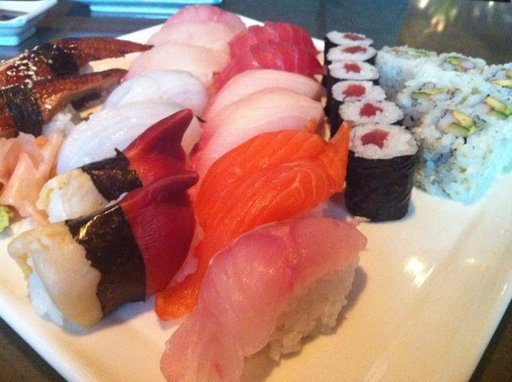

In [9]:
img_as_array

##3. Transforming Data.

Before we can use our image data with PyTorch:
1. Turn our Target data into tensors.
2. Turn it into `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader` , we will call these dataset and dataloader


In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

####3.1. Transforming data with `torchvision.transforms`

In [11]:
#Write a transform for image.
data_transform = transforms.Compose([
  #Resize our images to 64 x 64.
  transforms.Resize(size=(64, 64)),
  #Flip the images.
  transforms.RandomHorizontalFlip(p=0.5),
  #Turn the image into a torch.tensor
  transforms.ToTensor()

])

In [12]:
data_transform(img)

tensor([[[0.8118, 0.8471, 0.8392,  ..., 0.5216, 0.3137, 0.2824],
         [0.6745, 0.7765, 0.8314,  ..., 0.4392, 0.3490, 0.3333],
         [0.3686, 0.4471, 0.6471,  ..., 0.3412, 0.3059, 0.3412],
         ...,
         [0.3255, 0.3373, 0.3451,  ..., 0.2314, 0.2314, 0.2196],
         [0.3216, 0.3333, 0.3294,  ..., 0.2471, 0.2353, 0.2157],
         [0.3137, 0.3137, 0.3059,  ..., 0.2471, 0.2235, 0.2118]],

        [[0.9333, 0.9294, 0.9176,  ..., 0.5686, 0.3569, 0.3176],
         [0.7373, 0.8353, 0.9059,  ..., 0.4902, 0.4196, 0.3961],
         [0.3804, 0.5137, 0.7216,  ..., 0.3961, 0.3843, 0.4196],
         ...,
         [0.2510, 0.2588, 0.2745,  ..., 0.1765, 0.1765, 0.1647],
         [0.2471, 0.2431, 0.2549,  ..., 0.1686, 0.1647, 0.1608],
         [0.2314, 0.2275, 0.2275,  ..., 0.1647, 0.1529, 0.1490]],

        [[0.9451, 0.9294, 0.9176,  ..., 0.5333, 0.3686, 0.3412],
         [0.7725, 0.8471, 0.8941,  ..., 0.4824, 0.4235, 0.4314],
         [0.4824, 0.6039, 0.7569,  ..., 0.4000, 0.3843, 0.

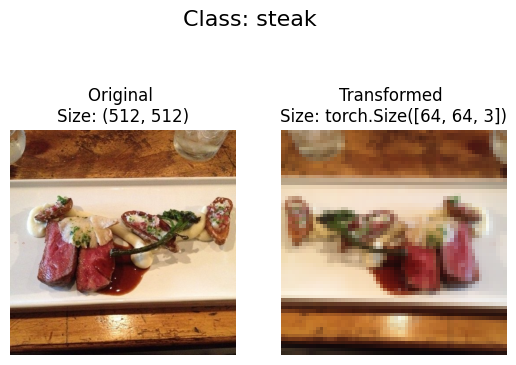

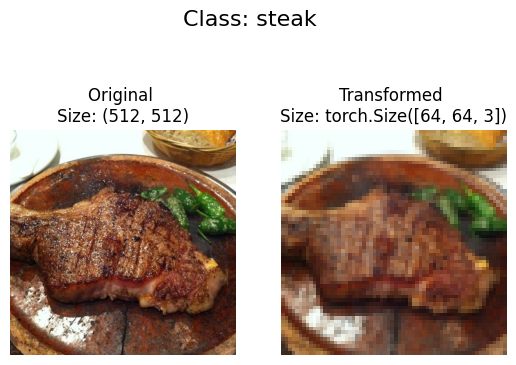

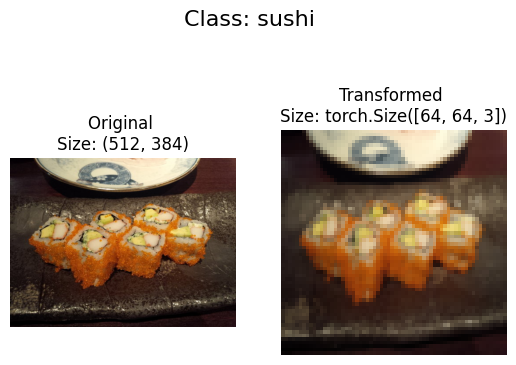

In [13]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3,
                        seed= None)

##4. Option 1: Loading image data using `imageFolder`

we can load image classification data using `torchvision.datasets.ImageFolder`
https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html

In [14]:
#Use imageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data.
                                  target_transform=None) #a transform for the label.
test_data = datasets.ImageFolder(root=test_dir,
                                 transform= data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [16]:
#Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [17]:
#Get class names as dict.
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [18]:
#Check the length of the dataset
len(train_data),len(test_data)

(225, 75)

In [19]:
#Index on train_data dataset to get a single image and dataset.
img,label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}  ")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels,height,width]
Image permute: torch.Size([64, 64, 3]) -> [height,width,color_channels]


Text(0.5, 1.0, 'pizza')

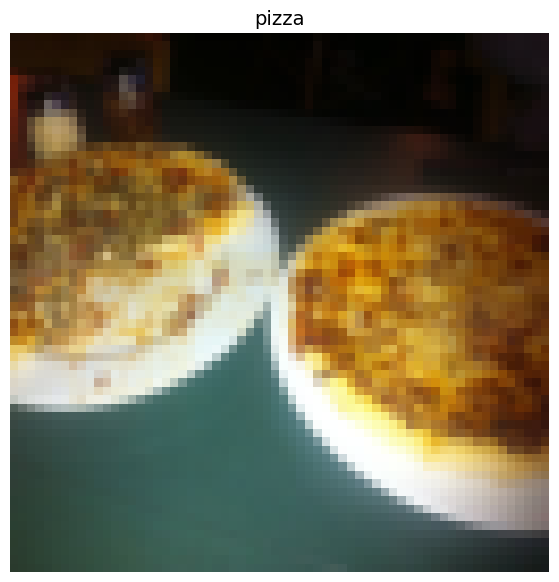

In [20]:
#Rearrange the order dimensions.
img_permute = img.permute(1,2,0)

#Print out what's happenin'
print(f"Original shape: {img.shape} -> [color_channels,height,width]")
print(f"Image permute: {img_permute.shape} -> [height,width,color_channels]")

#Plot the image.
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False);
plt.title(class_names[label], fontsize=14)

###4.1. Turn loaded images into dataloaders.

A dataloader is going to turn our data datasets into iterables and we can customize the `batch_size` images at a time.

In [21]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=False)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b9ac4326470>,
 <torch.utils.data.dataloader.DataLoader at 0x7b9ac4393a60>)

In [22]:
len(train_dataloader),len(test_dataloader)

(225, 75)

In [23]:
img,label = next(iter(train_dataloader))

#Batch size will now be 1, you can change the batch size if you like.
print(f"Image shape: {img.shape} -> [batch_size,color_channels,height,width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size,color_channels,height,width]
Label shape: torch.Size([1])


##5. Option 2: Loading Image Data with a custom `Dataset`.

1. Want to be able to load images into file.
2. Want to be able to get class names from dataset.
3. Want to be able to get classes as dictionary from the dataset.

Pros:
* Can create a `dataset` out of almost anything.
* Not limited o PyTorch pre-built `dataset` functions.

Cons:
* Even though you could create `dataset` out of almost anything it doesn't mean it will work.

* Using a custom `dataset` often results in us writing more code, which could be prone to errors or performance issues.


All custom datasets in PyTorch often subclass- https://pytorch.org/docs/stable/data.html

In [24]:
import os
import pathlib
import torch
from PIL import Image
from torchvision import transforms
from typing import Tuple,Dict,List

In [25]:
#Instance of torchvision.datasets.ImageFolder()
train_data.classes,train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

###5.1. Creating a helper fuction to get class names.

we want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory(ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [26]:
#Setup the target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

#Get the class names from the taregt directory.
class_names_found = sorted([entry.name for entry in list (os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [27]:
def find_classes(directory: str) -> Tuple[List[str],Dict[str,int]]:
  """Finds the class folde names in a arget directory. """
  #1.Get the class names by scanning the target directories.
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  #2. Raise an error if class names could not be found.
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}...please check file structure.")

  #3. Create a directory for index labels (computers prefers numbers to strings as labels).
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}


  #4. Raise an error if labels could not be found.
  if not class_to_idx:
    raise FileNotFoundError(f"Couldn't find any labels in {directory}...Please check file structure.")

  return classes, class_to_idx

In [28]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

###5.2. Create a custom `Dataset` to replicate ImageFolder.

To create our own dataset, we want to:
1. Subclass `torch.utils.data.dataset`
2. init our subclass with a target directory (the directory we would like to get data from) as well as  a transform if we would like to transform our data.
3. Create several attributes:
  * paths - paths of our image.
  * transform - the transform we'd like to use.
  * classes - a list of the target classes.
  * class_to_idx - a dict of the target classes mapped to integer labels.

4. Create a function to `load_images(), this function will open an image.
5. Overwrite the `__len()__` method to return the length of our dataset
6. overwrite the `__getitem()__` method to return a given sample when passed an index

In [29]:
#Write a custom dataset class
from torch.utils.data import Dataset

#1.Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  #2.Initialize our custom dataset.
  def __init__(self,
               targ_dir:str,
               transform:None):

    #3.Create class attributes.
    #Get all image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

    #setup transforms.
    self.transform = transform

    #Create classes and class_to_idx attributes.
    self.classes,self.class_to_idx = find_classes(targ_dir)

  #4. Create a function to load images.
  def load_image(self,
                 index:int):
    """Opens an image via path and returns it."""
    image_path = self.paths[index]
    return Image.open(image_path)

  #5. Overwrite __len__()
  def __len__(self) -> int:
    """Returns total number of paths."""
    return len(self.paths)

  #6.Overwrite __getitem__() method to return a particular function.
  def __getitem__(self, index) -> Tuple[torch.Tensor,int]:
    """Returns one sample of data and label (X,Y)"""
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    #Transform if necessary.
    if self.transform:
      return self.transform(img),class_idx #Return data label (X,Y)

    else:
      return img, class_idx #Return untransformed image and label.



In [30]:
#Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])



In [31]:

#Test out ImageFolder Custom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [32]:
train_data_custom,test_data_custom

(<__main__.ImageFolderCustom at 0x7b9ac43bf3a0>,
 <__main__.ImageFolderCustom at 0x7b9ac43bdf90>)

In [33]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [34]:
len(train_data),len(train_data_custom)

(225, 225)

In [35]:
len(test_data),len(test_data_custom)

(75, 75)

In [36]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [37]:
#Check for equality between the Original ImageFolder Dataset and ImageFolderCustom Dataset.

print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


###5.3. Create a function to display random images.

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. loop through the random sample indexes and plot them with matplotlib.
7. Make sure  the dimensions of our images line up with matplotlib(HWC)

In [38]:
#1. Create a function to take in a dataset.
def display_random_images(dataset:torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  #2. Adjust display if n is too high.
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes n should not be greater than 10, setting to 10 and removing the shape display.")

  #3. Set the seed.
  if seed:
    random.seed(seed)

  #4. Get random sample indexes.
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  #5. Setup Matplotlib plot
  plt.figure(figsize=(16,8))

  #6. Loop through the sample indexes and plot them using matplotlib.
  for i , targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0],dataset[targ_sample][1]

    #7. Adjust tensor dimensions for plotting.
    targ_image_adjust = targ_image.permute(1,2,0) #[color_channels ,height, width] -> [height,width,color_channels]


    #Plot adjusted samples.
    plt.subplot(1,n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False);
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nShape: {targ_image_adjust.shape}"
    plt.title(title)



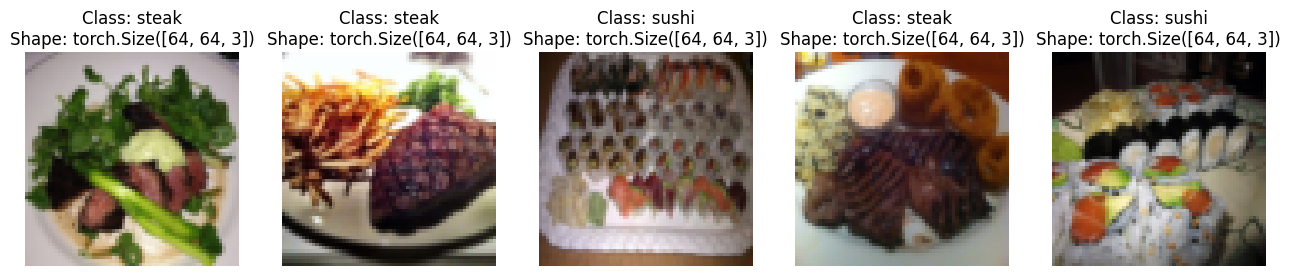

In [39]:
#Display random images from the ImageFolder created dataset.
display_random_images(train_data,
                      n = 5,
                      classes = class_names,
                      seed = None)

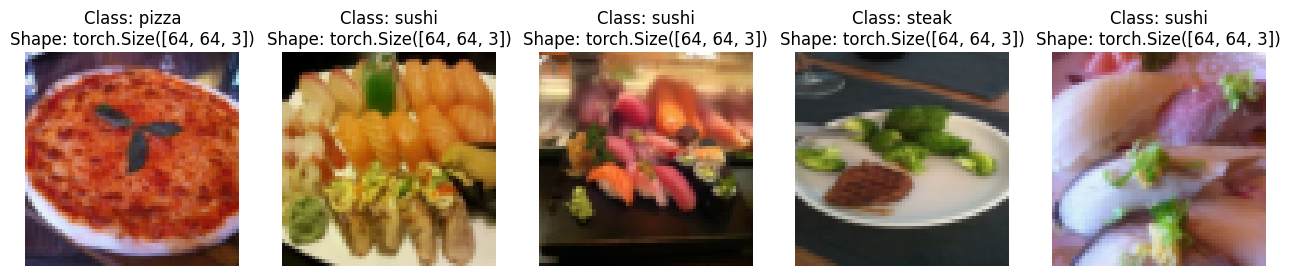

In [40]:
#Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n = 5,
                      classes = class_names,
                      seed = None)

###5.4 Turn custom loaded images into `Dataloader's`

In [41]:
from torch.utils.data import DataLoader
import os
BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                    batch_size= BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=0,
                                    shuffle=False)

train_dataloader_custom,test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7b9ac3a0fd60>,
 <torch.utils.data.dataloader.DataLoader at 0x7b9ac38f3760>)

In [42]:
#Get image and label from custom dataloader.
img_custom,label_custom = next(iter(train_dataloader_custom))

#Print out shape.
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

##6. Other forms of transforms (Data Augmentation).

`Data Augmentation` is the process of adding diversity to your training data.

In the case of image data, this may mean applying various image transformation to the training images.

This practice hopefully results in a model more generlizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

Blog post: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [43]:
#Let's take a look at tivial augment - https://pytorch.org/vision/main/generated/torchvision.transforms.TrivialAugmentWide.html

from torchvision import transforms

train_transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                     transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor()])


In [44]:
#Get all image path.
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:20]

[PosixPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2218680.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/540882.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/398345.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/344397.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/971934.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/714866.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2236338.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 PosixPath('data/pizza_steak_su

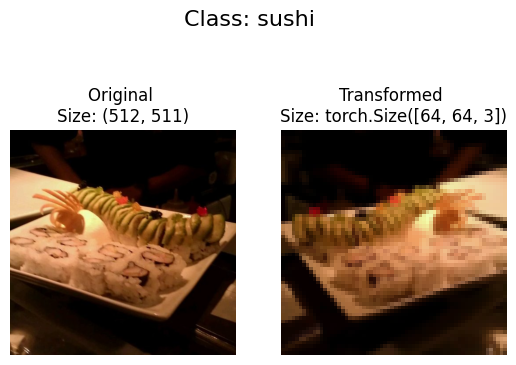

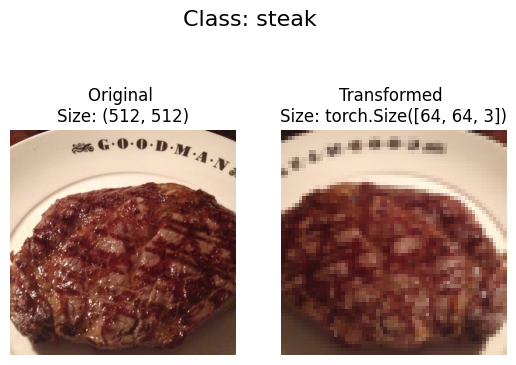

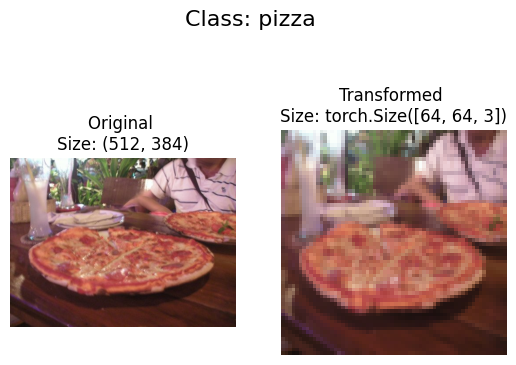

In [45]:
#Plot random transformed images.
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transforms,
    n = 3,
    seed = None
)

##7. Model 0 : TinyVGG without Data augmentation.

Let's replicate the TinyVGG architecture from the CNN explainer website.

See blog post: https://poloclub.github.io/cnn-explainer/

###7.1. Creating transforms and loading data for model_0

In [46]:
#create a simple transform.
simple_transform = transforms.Compose([transforms.Resize(size=(64,64)),
                                       transforms.ToTensor()])



In [47]:
#1.Load and transform data.
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

#2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

#Setup batch size and number of works.
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

#Create DataLoaders
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                    batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)


###7.2. Create a TinyVGG model class.

In [87]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN explainer: https://poloclub.github.io/cnn-explainer/

  """

  def __init__(self,input_shape:int,
               hidden_units:int,
               output_shape:int) -> None:

    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2,
                     stride=2) #Default stride value os same as the kernel size.
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2,
                     stride=2) #Default stride value os same as the kernel size.
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)

    x = self.conv_block_2(x)
    # print(x.shape)

    x = self.classifier(x)
    # print(x.shape)

    return x

    #return self.classifier(self.conv_block_2(self.conv_block_1(x))) #Benefits from operator fusion (speeds up GPU computations)



In [88]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape=3, #Number of color channels in our image data.
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

###7.3. Try a forward pass on a single image to test the model.


In [89]:
#Get a single image batch.
image_batch,label_batch = next(iter(train_dataloader_simple))
image_batch.shape,label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [90]:
#Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

###7.4. Use `torchinfo` to get an idea of the shapes going through our model.

In [91]:
try:
  import torchinfo

except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0,input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

###7.5. Create a train and test loop functions.

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.

* `test_step()` - takes in a model and a dataloader and evaluates the model on the dataloader.

In [102]:
#create a train step.
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  #Put the model in train mode.
  model.train()

  #Setup train loss and train acc values
  train_loss, train_acc = 0,0

  #Loop through dataloader and data batches
  for batch, (X,y) in enumerate(dataloader):
    #Send data to the target device.
    X,y = X.to(device),y.to(device)

    #1.Forward pass.
    y_pred = model(X) #Ouputs model logits.

    #2.Calculate the loss.
    loss = loss_fn(y_pred,y)
    train_loss +=loss.item()

    #3.Optimizer zero grad
    optimizer.zero_grad()

    #4. Loss backwards
    loss.backward()

    #5. Optimizer step
    optimizer.step()

    #Calculate the accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc +=(y_pred_class==y).sum().item()/len(y_pred)

  #Adjust metrics to get average loss and accuracy per batch.
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc




In [111]:
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device=device):
  #put the model in eval mode.
  model.eval()

  #setup the test_loss and test_acc values
  test_loss,test_acc = 0,0

  #Turn on inference mode
  with torch.inference_mode():

    #Loop through the data loader data batches.
    for batch, (X,y) in enumerate(dataloader):
      #Send data to target device.
      X,y = X.to(device),y.to(device)

      #1.Forward pass
      test_pred = model(X)

      #2.Calculate the test loss
      loss = loss_fn(test_pred,y)
      test_loss += loss.item()

      #3.Calculate the accuracy
      test_pred_class  = test_pred.argmax(dim=1)
      test_acc += (test_pred_class==y).sum().item()/ len(test_pred)



    #Adjust metrics to get average loss and accuracy per batch.
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


###7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [112]:
from tqdm.auto import tqdm
def train (model:torch.nn.Module,
           train_dataloader:torch.utils.data.DataLoader,
           test_dataloader:torch.utils.data.DataLoader,
           optimizer:torch.optim.Optimizer,
           loss_fn:torch.nn.Module = nn.CrossEntropyLoss(),
           epochs:int = 5):
  #2.Create empty results dictionary
  results = {
      "train_loss":[],
      "train_acc":[],
      "test_loss":[],
      "test_acc":[]
  }

  #Loop through the training and testing steps for a number of epochs.
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(
                                          model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer
                                      )

    test_loss,test_acc = test_step(model=model,
                                   dataloader=test_dataloader,
                                   loss_fn=loss_fn)


    # print out what's happenin'
    print(

        f"Epoch: {epoch+1} |"
        f"Train Loss: {train_loss:.4f} |"
        f"Test Acc: {test_acc:.4f} |"
        f"Test Loss: {test_loss:.4f} |"
        f"Test Acc: {test_acc:.4f} |")

    #Update the dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

###7.7. Train and evaluate `model 0`

In [113]:
#Set the random seeds.
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

#Recreate an instance of the TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

#Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),lr=0.01)

#start the timer
from timeit import default_timer as timer
start_timer = timer()

#Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

#End of the timer and print out how long it takes
end_timer = timer()

print(f"Total training time: {end_timer - start_timer:.2f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 |Train Loss: 1.2059 |Test Acc: 0.5417 |Test Loss: 1.1170 |Test Acc: 0.5417 |
Epoch: 2 |Train Loss: 1.1660 |Test Acc: 0.5417 |Test Loss: 1.0799 |Test Acc: 0.5417 |
Epoch: 3 |Train Loss: 1.1117 |Test Acc: 0.2282 |Test Loss: 1.1033 |Test Acc: 0.2282 |
Epoch: 4 |Train Loss: 1.1000 |Test Acc: 0.5417 |Test Loss: 1.0926 |Test Acc: 0.5417 |
Epoch: 5 |Train Loss: 1.0975 |Test Acc: 0.5417 |Test Loss: 1.0944 |Test Acc: 0.5417 |
Total training time: 10.25 seconds


###7.8. Ploot the loss curves of `model 0`

A **loss curve** is a way of tracking our model's progress overtime.

In [114]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [115]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

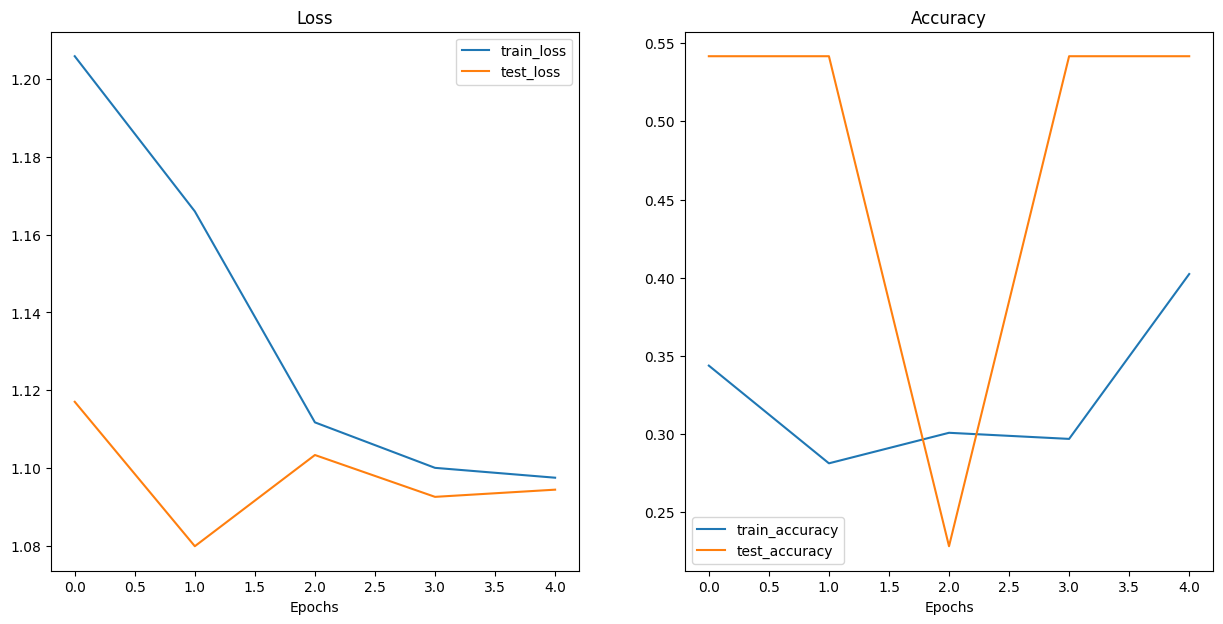

In [116]:

plot_loss_curves(model_0_results)

##8. What should an ideal loss curve look like.

See: https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

##9. Model_1: TinyVGG with Data Augmentation.

Now let's try another modelling experiement this time using the same model as before with some data augmentation.

###9.1. Create transform with data augmentation.

In [126]:
###9.1. Create a transform with data augmentation.
from torchvision import transforms
train_transform_trivial = transforms.Compose([
                                              transforms.Resize(size=(64,64)),
                                              transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                              transforms.ToTensor()])

test_transform_simple = transforms.Compose([transforms.Resize(size=(64,64)),
                                             transforms.ToTensor()])



###9.2. Create train and test `Dataset's` and `DataLoader's` with data augmentation.

In [127]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform_simple)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [128]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b9ac3a66ec0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b9ac4393a60>)

###9.3. Construct and train `model_1`


Now to build our next model, model_1, we can reuse our TinyVGG class from before.

In [129]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [130]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 |Train Loss: 1.1049 |Test Acc: 0.2604 |Test Loss: 1.1019 |Test Acc: 0.2604 |
Epoch: 2 |Train Loss: 1.0807 |Test Acc: 0.2604 |Test Loss: 1.1261 |Test Acc: 0.2604 |
Epoch: 3 |Train Loss: 1.0712 |Test Acc: 0.2604 |Test Loss: 1.1593 |Test Acc: 0.2604 |
Epoch: 4 |Train Loss: 1.1253 |Test Acc: 0.2604 |Test Loss: 1.1581 |Test Acc: 0.2604 |
Epoch: 5 |Train Loss: 1.0865 |Test Acc: 0.3333 |Test Loss: 1.1554 |Test Acc: 0.3333 |
Total training time: 14.379 seconds


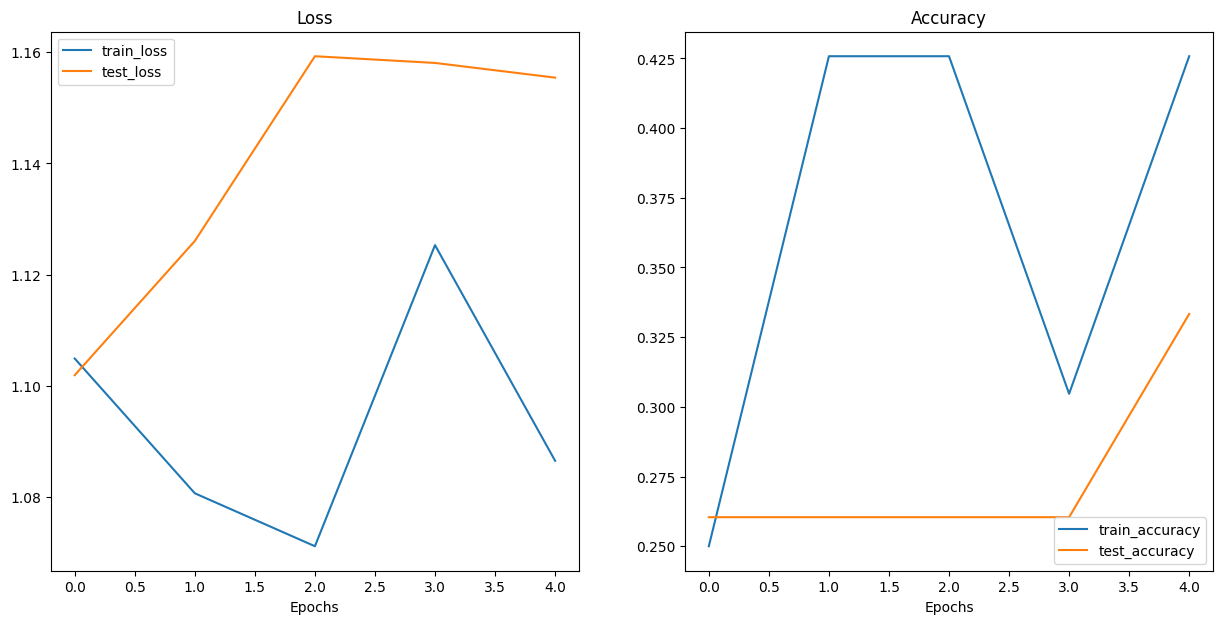

In [131]:

plot_loss_curves(model_1_results)

In [132]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.205924,0.343750,1.117028,0.541667
1,1.166011,0.281250,1.079871,0.541667
2,1.111730,0.300781,1.103334,0.228220
3,1.100031,0.296875,1.092570,0.541667
4,1.097497,0.402344,1.094420,0.541667


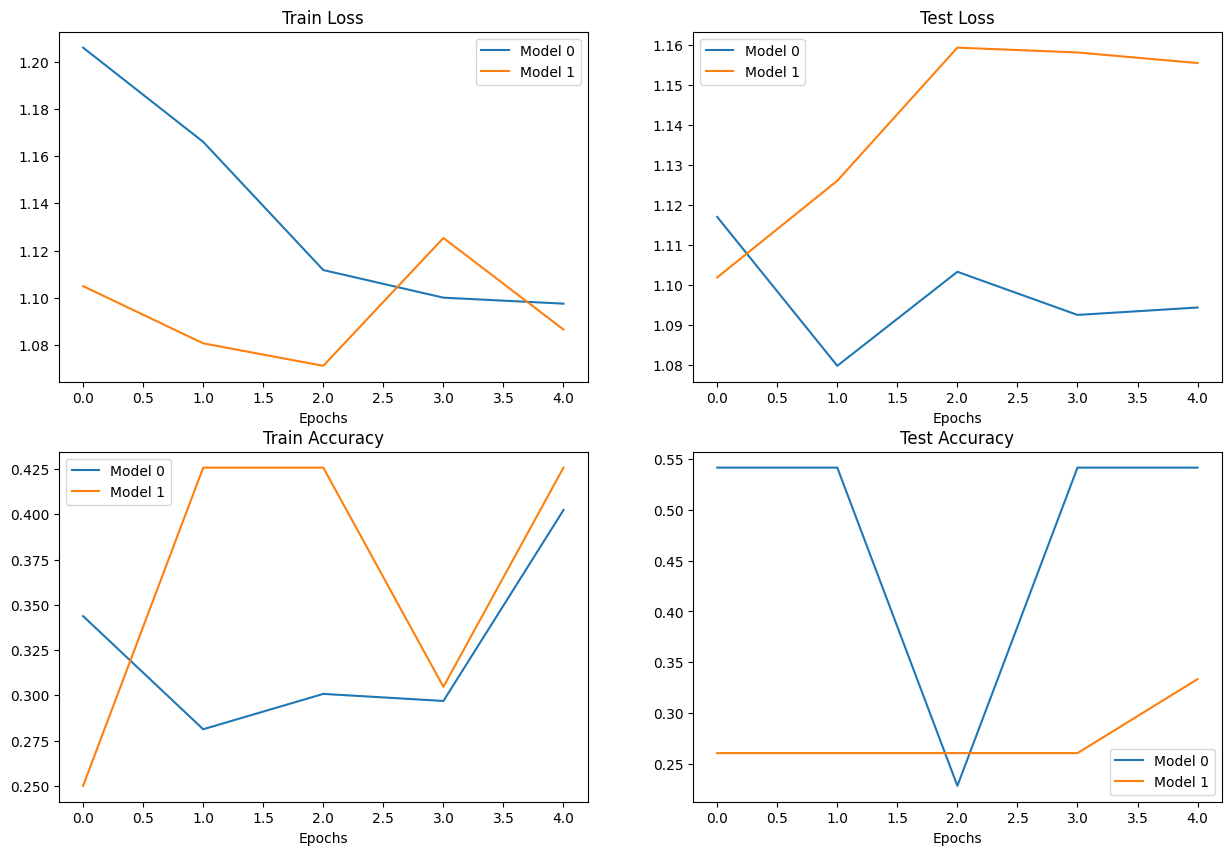

In [133]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();
